In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 11.7MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import fastai
fastai.__version__

'2.1.7'

In [3]:
# install the dependencies
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"userr2232","key":"1605e75a6f4e276797384afd8f121f51"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change permissions
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 96% 686M/714M [00:08<00:00, 118MB/s]
100% 714M/714M [00:08<00:00, 85.6MB/s]


In [7]:
from zipfile import ZipFile
file_name = 'lgg-mri-segmentation.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from fastai.callback.hook import *

In [ ]:
save_path = 'saved_model'

In [ ]:
get_mask_path = lambda x : x.parents[0] / (x.stem + '_mask' + x.suffix)

In [ ]:
data_path = Path('/content/lgg-mri-segmentation/kaggle_3m')
smalldata_path = data_path / 'TCGA_CS_4941_19960909'

In [ ]:
smalldata_path.ls()

(#46) [Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_21_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_9_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_5.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_8_mask.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960

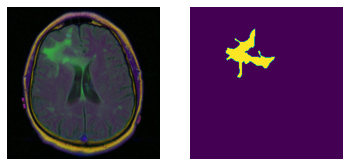

In [ ]:
sample_imgfile_path = smalldata_path/'TCGA_CS_4941_19960909_15.tif'
img = Image.open(sample_imgfile_path)
sample_maskfile_path = get_mask_path(sample_imgfile_path)
mask = Image.open(sample_maskfile_path)
show_images((img, mask))

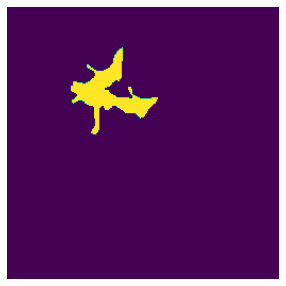

In [ ]:
show_image(mask, alpha=1)

In [ ]:
mask_t = cast(mask, TensorMask)
src_size = np.array(mask_t.shape)
src_size, mask_t.data

(array([256, 256]), TensorMask([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8))

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import gc
import humanize
import os
import GPUtil as GPU
import psutil

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=0446366575dc5251e9afe05b3cb34b73393e14a3ec199b202e7da65398732d75
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [ ]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
# XXX: only one GPU on Colab and isn’t guaranteed
def printm():
 process = psutil.Process(os.getpid())
 gc.collect()
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 325.0 MB
GPU RAM Free: 15069MB | Used: 10MB | Util   0% | Total 15079MB


In [ ]:
bs = 8
splitter = FuncSplitter(lambda posix_path: '_mask' in posix_path.name)
fnames = get_image_files(data_path)
images, masks = splitter(fnames)
images, masks = fnames[images], fnames[masks]
images, masks

((#3929) [Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_6.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_22.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_17.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_8.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_18.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_25.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_16.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_2.tif')...]

In [ ]:
codes = ['n', 'y']

In [ ]:
tfms = [IntToFloatTensor(div_mask=255), Brightness(0.1, p=0.25), Zoom(max_zoom=1.1,p=0.25), Normalize.from_stats(*imagenet_stats)]

In [ ]:
dls = SegmentationDataLoaders.from_label_func(data_path, images, get_mask_path, item_tfms=[Resize(src_size//2, method=ResizeMethod.Squish)], batch_tfms=tfms, valid_pct=0.2, codes=codes, seed=42, bs=bs)

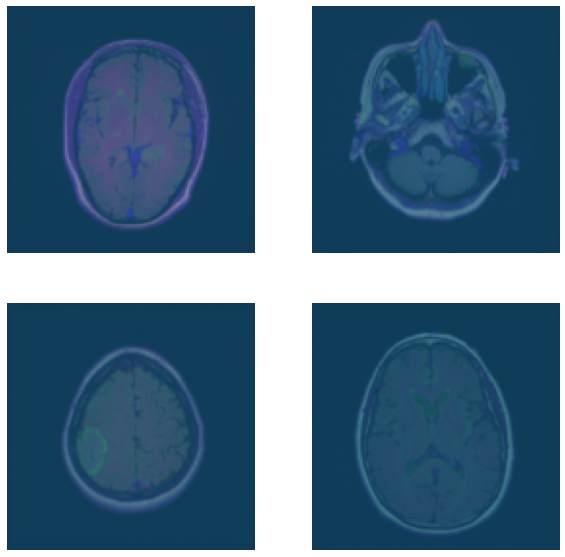

In [ ]:
dls.show_batch(max_n=4, figsize=(10, 10))

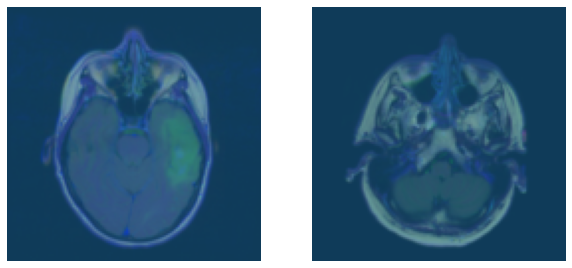

In [ ]:
dls.valid.show_batch(max_n=2, figsize=(10, 10))

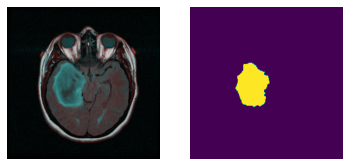

In [ ]:
show_images(dls.train_ds[2])

In [ ]:
t_mask = cast(dls.train_ds[2][1], TensorMask)
t_mask.argmax(dim=1)

TensorMask([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  98,  96,  90,
         89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  88,  87,  87,  86,
         85,  84,  83,  82,  80,  79,  79,  79,  79,  79,  80,  80,  80,  80,
         80,  80,  79,  79,  79,  78,  78,  78,  77,  77,  76,  76,  76,  77,
         78,  78,  80,  80,  80,  81,  81,  82,  82,  82,  83,  83,  83,  84,
         84,  84,  85,  86,  86,  86,  86,  87,  87,  88,  89,  93,  95, 105,
        106,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Model

In [ ]:
def acc_brain(input, target):
  target = target.squeeze(1)
  return (TensorBase(input.argmax(dim=1)) == TensorBase(target)).float().mean()

In [ ]:
from fastai.vision.models import resnet34

learn = unet_learner(dls, resnet34, metrics=acc_brain, path=save_path)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=3.0199516913853586e-05)

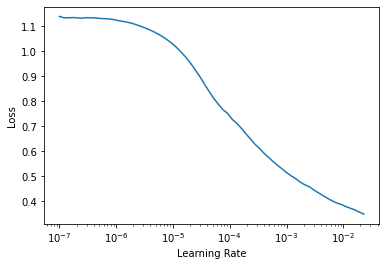

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr)) # Because of a fastai's bug, I cannot use Dice for now: https://github.com/fastai/fastai/issues/3041

epoch,train_loss,valid_loss,acc_brain,time
0,0.024597,0.020008,0.993170,00:56
1,0.016114,0.015731,0.994522,00:57
2,0.011044,0.015927,0.993965,00:58
3,0.007361,0.008180,0.997054,00:58
4,0.006645,0.007840,0.997128,00:59
5,0.005439,0.006775,0.997489,00:59
6,0.004536,0.006355,0.997626,00:59
7,0.004144,0.006228,0.997656,00:59
8,0.003983,0.006322,0.997690,00:59
9,0.003830,0.006554,0.997646,00:59


In [ ]:
learn.save('stage-1')

Path('saved_model/models/stage-1.pth')

In [ ]:
learn.load('stage-1')

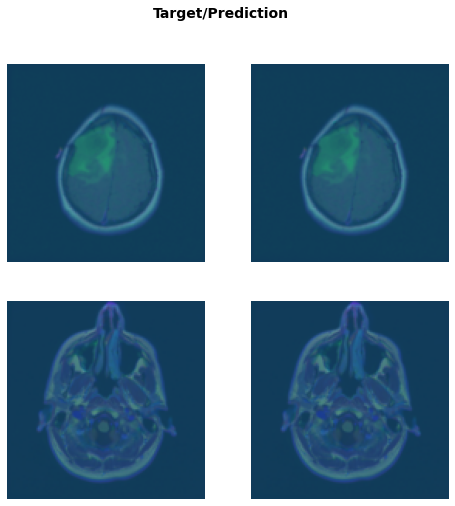

In [ ]:
learn.show_results(max_n=8, figsize=(8,8))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.1)

epoch,train_loss,valid_loss,acc_brain,time
0,0.003994,0.006375,0.997677,01:05
1,0.004169,0.006293,0.997726,01:05
2,0.003586,0.006401,0.997703,01:05
3,0.003577,0.006300,0.997730,01:05
4,0.003304,0.006394,0.997691,01:05
5,0.003186,0.006864,0.997674,01:05
6,0.003378,0.006450,0.997737,01:05
7,0.003138,0.006588,0.997744,01:04
8,0.002851,0.006334,0.997774,01:05
9,0.002901,0.006672,0.997729,01:05


In [ ]:
learn.save('stage-2')

Path('saved_model/models/stage-2.pth')

# Full size

At this point, it is recommended to restart the kernel

In [9]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.1.7)


In [10]:
import fastai
fastai.__version__

'2.1.7'

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
from fastai.callback.hook import *

In [12]:
def acc_brain(input, target):
  target = target.squeeze(1)
  return (TensorBase(input.argmax(dim=1)) == TensorBase(target)).float().mean()

In [13]:
class Dice(Metric):
    "Dice coefficient metric for binary target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        pred, targ = TensorBase(pred), TensorBase(targ)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()

    @property
    def value(self): return 2. * self.inter/self.union if self.union > 0 else None

In [14]:
get_mask_path = lambda x : x.parents[0] / (x.stem + '_mask' + x.suffix)

In [15]:
bs = 4
codes = ['n', 'y']

In [17]:
data_path = Path('/content/lgg-mri-segmentation/kaggle_3m')

In [18]:
splitter = FuncSplitter(lambda posix_path: '_mask' in posix_path.name)
fnames = get_image_files(data_path)
images, masks = splitter(fnames)
images, masks = fnames[images], fnames[masks]
images, masks

((#3929) [Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_6.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_22.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_17.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_8.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_18.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_13.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_11.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_25.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_16.tif'),Path('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_2.tif')...]

In [19]:
tfms = [IntToFloatTensor(div_mask=255), Brightness(0.1, p=0.25), Zoom(max_zoom=1.1,p=0.25), Normalize.from_stats(*imagenet_stats)]

In [20]:
dls = SegmentationDataLoaders.from_label_func(data_path, images, get_mask_path, batch_tfms=tfms, valid_pct=0.2, codes=codes, seed=42, bs=bs)

In [21]:
save_path = 'saved_model'

In [23]:
from fastai.vision.models import resnet34
metrics = [acc_brain, Dice()]
learn = unet_learner(dls, resnet34, metrics=metrics, path=save_path)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [26]:
learn.load('stage-2')

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=6.309573450380412e-07)

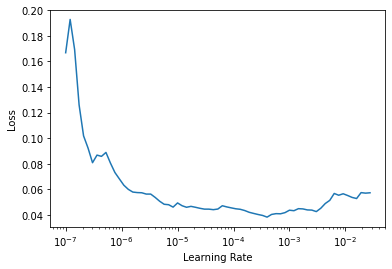

In [27]:
learn.lr_find()

In [28]:
lr = 1e-4

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.5)

epoch,train_loss,valid_loss,acc_brain,dice,time
0,0.010067,0.010052,0.996411,0.830333,03:10
1,0.011426,0.008195,0.996997,0.859100,03:08
2,0.008477,0.009340,0.996491,0.837425,03:08
3,0.005729,0.008066,0.997186,0.853658,03:07
4,0.006085,0.007363,0.997285,0.861496,03:06
5,0.005210,0.007007,0.997507,0.881908,03:08
6,0.005126,0.007774,0.997524,0.874531,03:07
7,0.003455,0.006821,0.997642,0.882080,03:07
8,0.003441,0.006470,0.997842,0.895364,03:07
9,0.002696,0.006452,0.997875,0.898350,03:07


In [30]:
learn.save('stage-1-big')

Path('saved_model/models/stage-1-big.pth')

In [31]:
learn.load('stage-1-big')

In [32]:
learn.unfreeze()

In [33]:
lrs = slice(1e-6, lr/10)

In [34]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_brain,dice,time
0,0.002849,0.007014,0.997808,0.893191,03:23
1,0.002969,0.006710,0.997832,0.897153,03:23
2,0.002679,0.006711,0.997847,0.897271,03:22
3,0.002577,0.007088,0.997816,0.894323,03:22
4,0.002738,0.006751,0.997835,0.897266,03:22
5,0.002616,0.007065,0.997842,0.895465,03:21
6,0.002541,0.007171,0.997862,0.896932,03:22
7,0.002780,0.007096,0.997850,0.896390,03:21
8,0.002373,0.007145,0.997850,0.896437,03:21
9,0.002638,0.007105,0.997848,0.896310,03:24


In [35]:
learn.save('stage-2-big')

Path('saved_model/models/stage-2-big.pth')

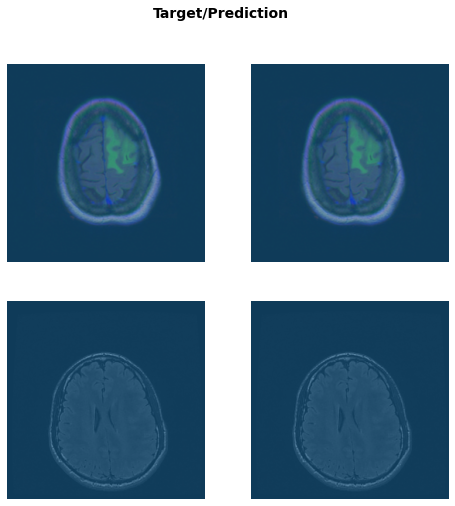

In [41]:
learn.show_results(figsize=(8, 8))